# Introduction 

Before working on this notebook, please make sure you have correctly set up the conda environment with all requisite packages, and that you have at least one molecular editor, such as PyMOL or MOE, installed that allows you to conveniently visualize our starting protein structure. Also, there should be the `GFP_SSRL_final.pdb` and `6jgi.pdb` files in the folder. The goal of this notebook is to introduce how to clean up the initial protein structure (from our lab's x-ray diffraction experiments) before we construct the crystal system for MD simulation. There are five 
issues that we need to take care of for our eGFP protein:

* Missing OXT (terminal oxygen) on Thr230. 
* Incorrect tyrosyl protonation state at the chromophore (Cro66).
* Missing CONECT record for the chromophore in the PDB file.
* Some uncertain protonation states for charged residues (Asp, Glu, Lys, Arg, His).
* Protonate the surface and structural waters resolved from crystallography.

We will take care of these points one by one, explaining the subtleties along the way. Although I originally performed some of these tasks in GUI environments, I now try to do these by python codes just to make everything fully reproducible. 

# Step 1: Fix the missing OXT on Thr230.

Let us fire up Coot and visualize the electron density map at the C-terminus of our eGFP structure. We can see that the side chain has clear density but the carboxylic acid group does not, i.e., the OXT atom is missing. If we try to visualize the structure with PyMol we'd see weird bonding pattern there. But this is easy to fix with PDBFixer which can automatically detect missing heavy atom from the chain termini. The snippet in the next code cell will take in the starting structure `GFP_SSRL_final.pdb` and produces an intermediate file `GFP_SSRL_final_1.pdb`. We will serially process the intermediate files until we reach at `lab_fixed.pdb` in the end.

<br/><br/>


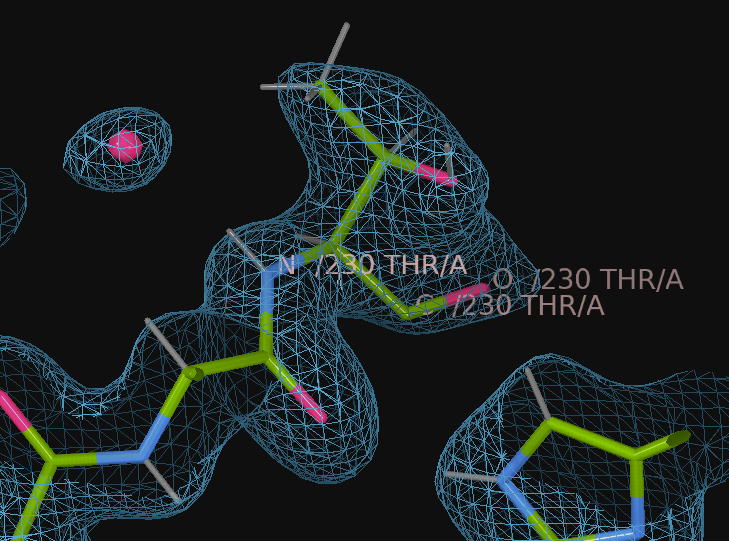
<p><center>
Figure 1: Electron density map at Thr230, contour level at rmsd=0.7
</center></p>



In [1]:
from pdbfixer import PDBFixer
from openmm.app import PDBFile

fname = 'GFP_SSRL_final'

egfp = PDBFixer(filename=f'{fname}.pdb')
egfp.findMissingResidues()
egfp.findMissingAtoms()
egfp.addMissingAtoms()
PDBFile.writeFile(egfp.topology, egfp.positions, open(f'{fname}_1.pdb', 'w'), keepIds=True) # keepIds=True to not renumber resid ids

# Step 2: Modify the protonation state at the chromophore

Okay, let me just cite this paragraph from Takaba et al. to explain a bit about the biochemistry of eGFP:

> Green fluorescent protein (GFP), which was discovered in the
jellyfish Aequorea victoria, is a light-emitting protein consisting
of 238 amino acids. GFP absorbs UV–blue light and emits
green light. The structure consists of an 11-stranded $\beta$-barrel
plugged by a chromophore [Fig. 1(a)]. The chromophore is
4-(p-hydroxybenzylidene)imidazolin-5-one, which is formed
from three intrinsic residues (Ser65, Tyr66 and Gly67) in the
polypeptide chain by a post-translational cyclization, dehydration
and oxidation. **There are dual protonation states of the
hydroxybenzyl (tyrosyl) group of the chromophore in the
protein. The protonated neutral ‘A’ and deprotonated anionic
‘B’ forms [Fig. 1(b)] are present at ratios of 6:1 to 4:1 in wildtype
GFP (Brejc et al., 1997; Chattoraj et al., 1996). The two
forms have distinct spectroscopic properties (Chattoraj et al.,
1996). The absorption peak at 398 nm belongs to the A-form
chromophore, while the peak at 475 nm belongs to the B form
[Supplementary Fig. S1(a)].**

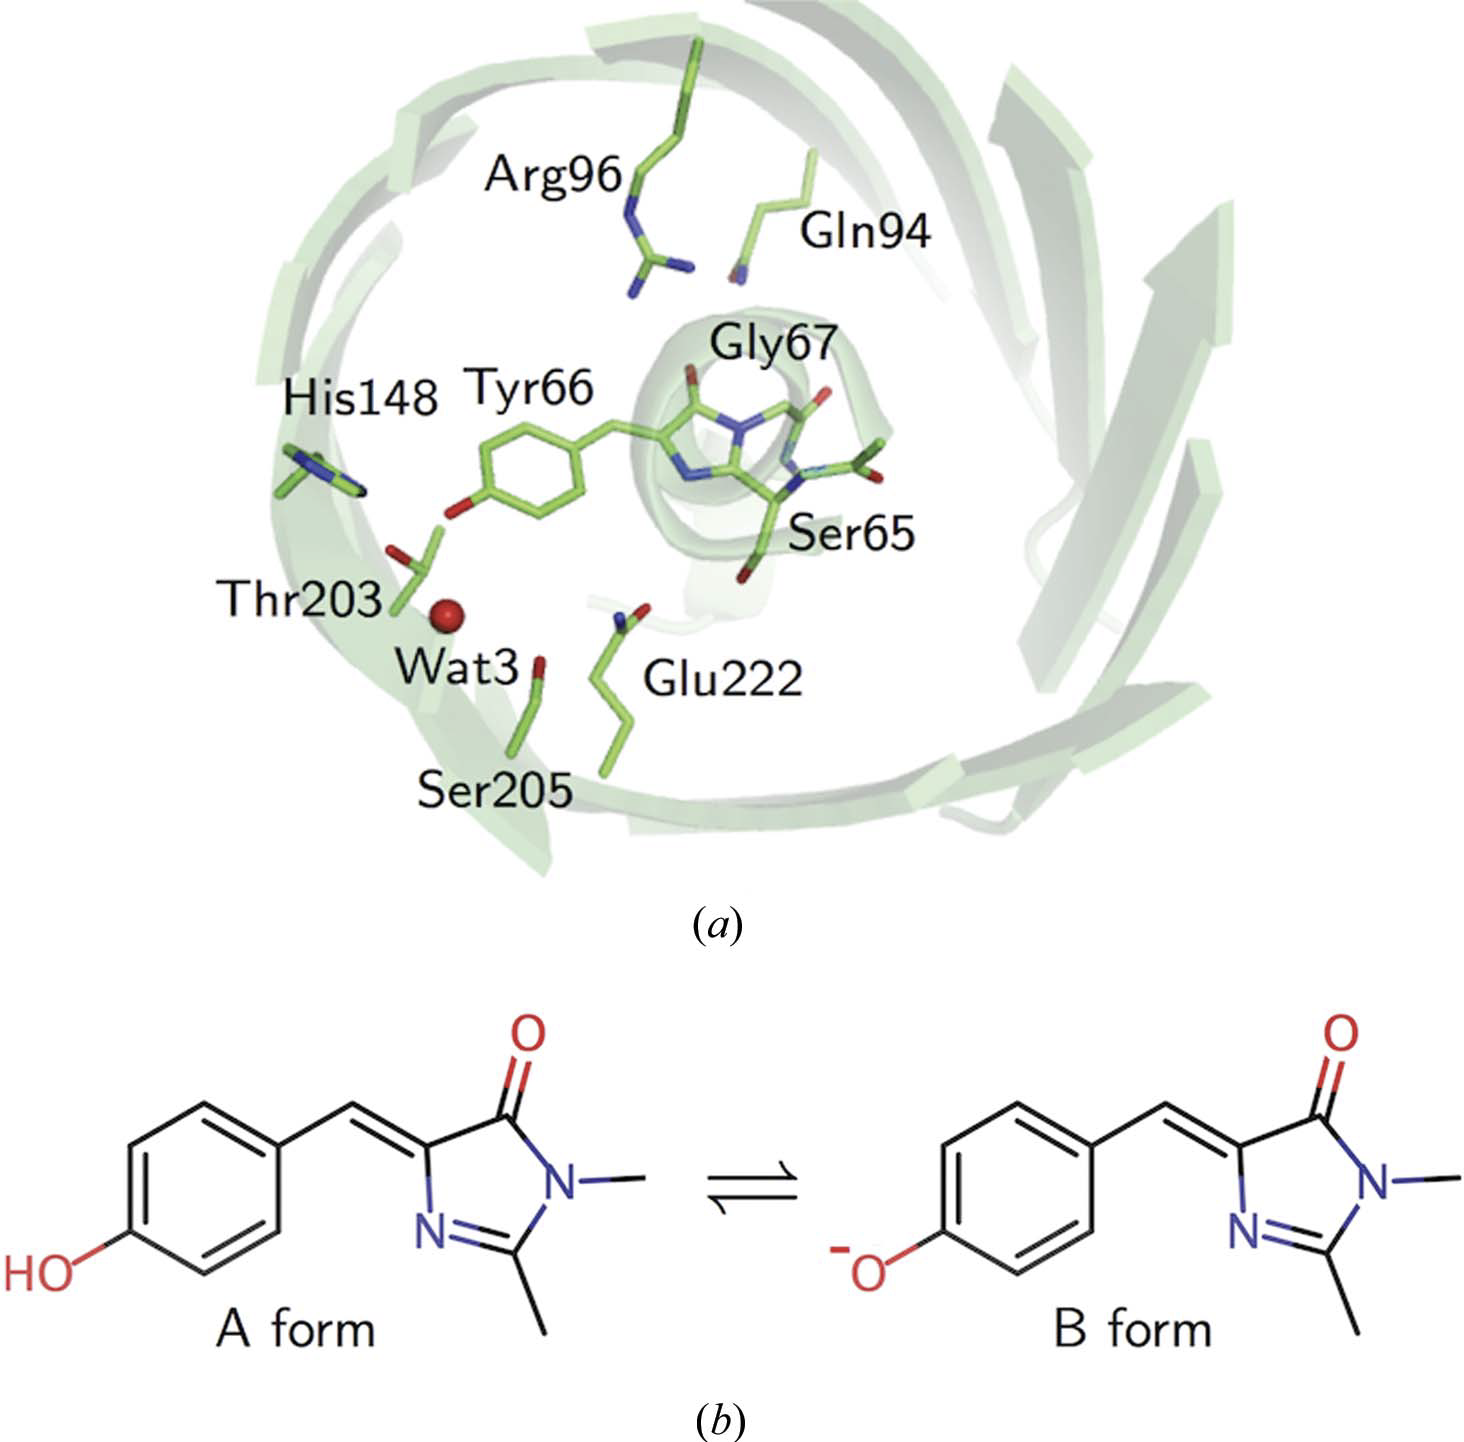
<p><center>
Figure 2: The structure of GFP from A. victoria and the dual protonation states of the chromophore.
</center></p>


So the idea is that the original GFP has dual protonation states of the chromophore, but in eGFP the deprotonated, cationic state is dominant (can see that from the excitation spectrum). In our lab structure, we didn't have any density for to support protonation/deprotonation for the chromophore (cite Jack from Slack, June 24). However, since we are using eGFP, we can confidently set the chromophore to the cationic state by stripping away a hydrogen. This is handled by using the python package for pymol. 

# Step 3: Add the missing CONECT record for the chromophore
Now a bit about bioinformatics...I will cite this from PDB spec that you can find online: 
> The CONECT records specify connectivity between atoms for which coordinates are supplied. The connectivity is described using the atom serial number as shown in the entry. CONECT records are mandatory for HET groups (excluding water) and for other bonds not specified in the standard residue connectivity table.

Hence, we must add these records for the chromophore, or in the later step, OpenMM will not be able to build the correct topology for the chromophore when we construct the crystal system. Fortunately, by reading/saving the PDB file  using pymol we can get the records added for free. How easy is that?!

Note: the `pdb_use_ter_records` line suppresses adding `TER`, otherwises pymol erroneously denote Leu64 as a terminus because there's a jump from Leu64 to Cro66 in the original numbering. The missing `TER`s should not affect subsequent steps in this tutorial, although the resulting file is not exactly PDB format compliant because the format requires a `TER` at the C-terminus of a protein. Anyway, if we do not suppress adding `TER`, then we need to manually remove the first occurent after Leu64.

In [2]:
from pymol import cmd
cmd.set('pdb_retain_ids', 1) # so it doesn't mess up our residue ids
cmd.load(f'{fname}_1.pdb', 'egfp')
cmd.select('sele', 'n. HOH and i. 66')
cmd.remove('sele')
cmd.set('pdb_use_ter_records', 0)
cmd.save(f'{fname}_2.pdb', 'egfp')

# Step 4: Modify protonation states for charged residues

To produce a realistic MD simualation we need to protonate the charged residues correctly according to their pH and interactions with neighboring groups. In structures resolved from X-ray diffraction we usually cannot see electron densities for hydrogens directly, though we could rely on OMIT maps to decide where to place some hydrogens. Here, we use the structure (PDB: 6L26) obtained by neutron crystallography on a GFP variant similar to ours to assign the protonation states. See the end of the notebook for a comment on how this is done automatically.

To attain maximum confidence in our assignments, I and Doeke had actually checked the residues one by one, and we decided to transfer the protonation states at H148 and E222. These protonation states are additionally confirmed by the high resolution (0.8Å) X-ray structure of the S65T variant studied by Takaba et al.



In [3]:
from openmm.app.modeller import Modeller
from openmm.app.pdbfile import PDBFile
from functools import lru_cache
from itertools import islice

def nth(iterable, n, default=None):
    "Returns the nth item or a default value"
    return next(islice(iterable, n, None), default)

src_chain_ids = {0: 0}

src_dir = '6l26.pdb'
tgt_dir = f'{fname}_2.pdb'
out_dir = f'{fname}_3.pdb'
forcefield = None

src = PDBFile(src_dir)
tgt = PDBFile(tgt_dir)
tgt_mask = [17, 25, 139] # this defines the residue we want to keep in our lab structure

# default residue names to the neutral variant (aliasing)
# but this doesn't work as I realize that PDBFile does not store residue variant, 
# need to do the checking by my self
mapping = {'ASH': 'ASH', 'ASP': 'ASH', 'CYS': 'CYS', 'CYX': 'CYS', 'GLH': 'GLH', 'GLU': 'GLH', 
           'HID': 'HID', 'HIE': 'HID', 'HIP': 'HID', 'HIN': 'HID', 'LYN': 'LYN', 'LYS': 'LYN'}
def get_default_resid_name(n):
    if n in mapping:
        return mapping[n]
    else:
        return n

# find longest common subsequence, return tuples of indices of matching elements from the two seqs
def lcs(seq1, seq2):
    @lru_cache(maxsize=None)
    def helper(idx1 = 0, idx2 = 0):
    
        if idx1 == len(seq1) or idx2 == len(seq2):
            return []
            
        if seq1[idx1] == seq2[idx2]:
            return  [(idx1, idx2)] + helper(idx1 + 1, idx2 + 1)
        
        option1 = helper(idx1 + 1, idx2)
        option2 = helper(idx1, idx2 + 1)
        
        return max(option1, option2, key=len)
    
    return helper()

# returns the 3 letter amino acid residue code for the protonation variant
def assign_protonation_variants(atoms_iter, res_code):
    atom_code_lst = [a.name for a in atoms_iter] 
    # check if (a) particular atom(s) appears and return the residue code if so
    def check_atom(atom_code, res_code):
        if atom_code in atom_code_lst:
            return res_code
        
    if res_code == 'ASP':
        if any(x in atom_code_lst for x in ['HD2', 'DD2']):
            return 'ASH'
        else:
            return 'ASP'
    elif res_code == 'CYS':
        if any(x in atom_code_lst for x in ['HG', 'DG']):
            return 'CYS'
        else:
            return 'CYX'
    elif res_code == 'GLU':
        if  any(x in atom_code_lst for x in ['HE2', 'DE2']):
            return 'GLH'
        else:
            return 'GLU'
    elif res_code == 'HIS':
        if any(x in atom_code_lst for x in ['HD1', 'DD1']):
            if any(x in atom_code_lst for x in ['HE2', 'DE2']):
                return 'HIP'
            else:
                return 'HID'
        elif any(x in atom_code_lst for x in ['HE2', 'DE2']):
            return 'HIE'
        else:
            return 'HIN'
    elif res_code == 'LYS':
        if any(x in atom_code_lst for x in ['HZ1', 'DZ1']):
            return 'LYS'
        else:
            return 'LYN'
    # either the residue has been already assigned a protonation variant
    # or for the remaining amino acids there's no alternative protonation states possible
    else:
        return res_code
    
full_mask = []
for tgt_chain_id, tgt_chain in enumerate(tgt.topology.chains()):
    mask = [None] * len(list(tgt_chain.residues()))
    src_chain_id = src_chain_ids.get(tgt_chain_id)
    if src_chain_id is not None:
        src_chain = nth(src.topology.chains(), src_chain_id)
        tgt_chain = nth(tgt.topology.chains(), tgt_chain_id)
        src_resids = [assign_protonation_variants(resid.atoms(), resid.name) for resid in src_chain.residues()]
        tgt_resids = [assign_protonation_variants(resid.atoms(), resid.name) for resid in tgt_chain.residues()]
        for src_idx, tgt_idx in lcs([get_default_resid_name(n) for n in src_resids], 
                                    [get_default_resid_name(n) for n in tgt_resids]):
            if src_resids[src_idx] in mapping:
                if tgt_resids[tgt_idx] != src_resids[src_idx]:
                    if tgt_idx in tgt_mask:
                        print(f'Residue {nth(tgt_chain.residues(), tgt_idx).id} in target aligned with {nth(src_chain.residues(), src_idx).id}' + 
                              f' in source, kept as {tgt_resids[tgt_idx]} ({src_resids[src_idx]} in ref structure).')
                    else:
                        print(f'Residue {nth(tgt_chain.residues(), tgt_idx).id} in target aligned with {nth(src_chain.residues(), src_idx).id}' + 
                              f' in source, changed from {tgt_resids[tgt_idx]} to {src_resids[src_idx]}.')
                        mask[tgt_idx] = src_resids[src_idx]
    full_mask += mask

tgt_modeller = Modeller(tgt.topology, tgt.positions)
tgt_modeller.addHydrogens(forcefield, variants = full_mask)
PDBFile.writeFile(tgt_modeller.topology, tgt_modeller.positions, open(out_dir, 'w'))

/Users/ziyuanzhao/opt/anaconda3/envs/openmm2/lib/python3.9/site-packages/openmm/app/internal/pdbstructure.py:538: UserWarning: WARNING: duplicate atom (ATOM     10  H   MET A   3      -2.993  19.934 -16.328  1.00  0.00           H  , ATOM      9  H   MET A   3      -2.981  19.959 -16.350  1.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))


Residue 17 in target aligned with 17 in source, kept as GLU (GLH in ref structure).
Residue 25 in target aligned with 25 in source, kept as HIE (HIP in ref structure).
Residue 139 in target aligned with 139 in source, changed from HID to HIP.
Residue 148 in target aligned with 148 in source, changed from HID to HIP.
Residue 222 in target aligned with 222 in source, changed from GLU to GLH.


Finally, we can see for which residues we have modified the protonation state of our lab structure to match that of the 6jgi structure as above, and also the alignment between the source and target structures.

# Step 5: Protonate waters resolved from crystallography
Well, hydrogen atoms only have one electron each and these density are strongly skewed by the polar bonds they make to other electronegative atoms, so that's a quick justification of why it's very hard to see them in conventional X-ray crystallography methods. But we have a bunch of resolved waters (inferred from oxygen electron density), some on the surface, and the others are in the protein. We can use OpenMM's modeller to automatically handle adding hydrogens, but then a valid question is, since hydrogen bonds are highly directional, that a random assignment of hydrogen locations may disturb the intricate bonding networks inside the protein. Gladly we don't have to, since we have the neutron structures for reference, and the following figure shows that structure overlaid upon our lab structure. 

As we can see in the figure below, the oxygen positions in our lab structure matched pretty well with the neutron structure inside the protein, so we can confidently transfer the entire water molecules from the neutron structure to ours (of course, after align the structures first). But in the next code snippet I will show how to do a bit more elaborate checking. I will first, for our lab structure and the neutron diffraction structure, identify the waters that are inside or outside of the eGFP protein, and then compute the pairwise RMSD matrix for each to quantify how well the waters line up between the structures.

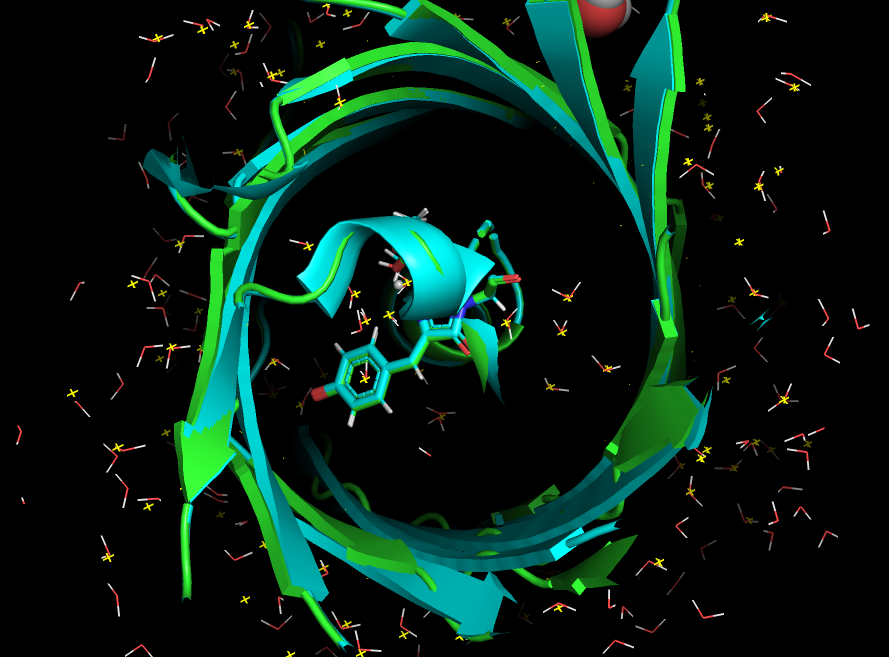
<p><center>
Figure 3: The view through the GFP barrel for the aligned structures from our lab and the neutron diffraction experiment. The yellow crosses are oxygens determined in our structure and the red waters are from the neutron structure. They agree pretty well in number and in locations inside the barrel.
</center></p>

In [4]:
import mdtraj
import itertools
import numpy as np
import pyKVFinder

def replace_deuterium(pdb, overwrite=True):
    """
    Replace all deuterium atoms in a structure with normal hydrogen. Completely relabel heavy waters as well.
    
    kwargs:
    pdb -- the structure (with water) to work on, specified as the path to the `.pdb` file
    
    Note: deuteriums on a.a. residues will **not** be relabelled to their hydrogen counterparts
    """
    with open(pdb, 'r') as f:
        newText=f.read().replace(' D  ', ' H  ').\
                         replace('D   ', 'H   ').\
                         replace('D1  ', 'H1  ').\
                         replace('D2  ', 'H2  ').\
                         replace('DOD ', 'HOH ')
    with open(pdb if overwrite else pdb.replace('.pdb', '_dedeuterated.pdb'), "w") as f:
        f.write(newText)
    
def group_waters_from_pdb(pdb, probe_in=0, probe_out=4.0):
    """
    Group waters in a structure according to whether they are in cavities or not.
    
    kwargs:
    pdb -- the structure (with water) to work on, specified as the path to the `.pdb` file
    """
    # preproc
    dry_pdb = pdb.replace('.pdb', '_dry.pdb')
    cav_pdb = pdb.replace('.pdb', '_cav.pdb')
    structure = mdtraj.load(pdb)
    structure.remove_solvent().save(dry_pdb)
    
    # generate grid and compute cavity points over grid
    vertices = pyKVFinder.get_vertices(pyKVFinder.read_pdb(dry_pdb), probe_out=probe_out)
    ncav, cavities = pyKVFinder.detect(pyKVFinder.read_pdb(dry_pdb), vertices, 
                                       probe_in=probe_in, probe_out=probe_out)
    pyKVFinder.export(cav_pdb, cavities, None, vertices)
    
    # check cavity points at oxygen coord over grid
    water_idx = structure.top.select("is_water and name O") 
    water_coords = structure.xyz[0, water_idx, :]
    water_coords_grid = ((water_coords * 10 - vertices[0,:])//0.6).astype("int") #0.6A grid
    cavities_water_subset = np.array([cavities[xyz[0], xyz[1], xyz[2]] for xyz in water_coords_grid])
    # prepare return vals
    bound_idx, bulk_idx = np.where(cavities_water_subset>=2)[0], np.where(cavities_water_subset<2)[0]
    water_resids = np.array([r for r in structure.top.residues if r.is_water])
    bound_resids, bulk_resids = water_resids[bound_idx], water_resids[bulk_idx]
    bound_oxy_atoms, bulk_oxy_atoms = water_idx[bound_idx], water_idx[bulk_idx]
    bound_coords, bulk_coords = water_coords[bound_idx,:], water_coords[bulk_idx,:]
    return bound_resids, bulk_resids, bound_coords, bulk_coords

replace_deuterium('./6l26.pdb')
neutron_structure, lab_structure = mdtraj.load('./6l26.pdb'), mdtraj.load(f'{fname}_2.pdb')
neutron_structure.superpose(lab_structure, atom_indices=neutron_structure.top.select('is_backbone and resid>0'), 
                                           ref_atom_indices=lab_structure.top.select('is_backbone and resid>3')).save('./6l26.pdb')
neutron_bound_resids, neutron_bulk_resids, neutron_bound_coords, neutron_bulk_coords,  = group_waters_from_pdb('./6l26.pdb')
lab_bound_resids, lab_bulk_resids, lab_bound_coords, lab_bulk_coords, = group_waters_from_pdb(f'{fname}_3.pdb')

Text(0.5, 0, 'Min distance to neutron structure (Å)')

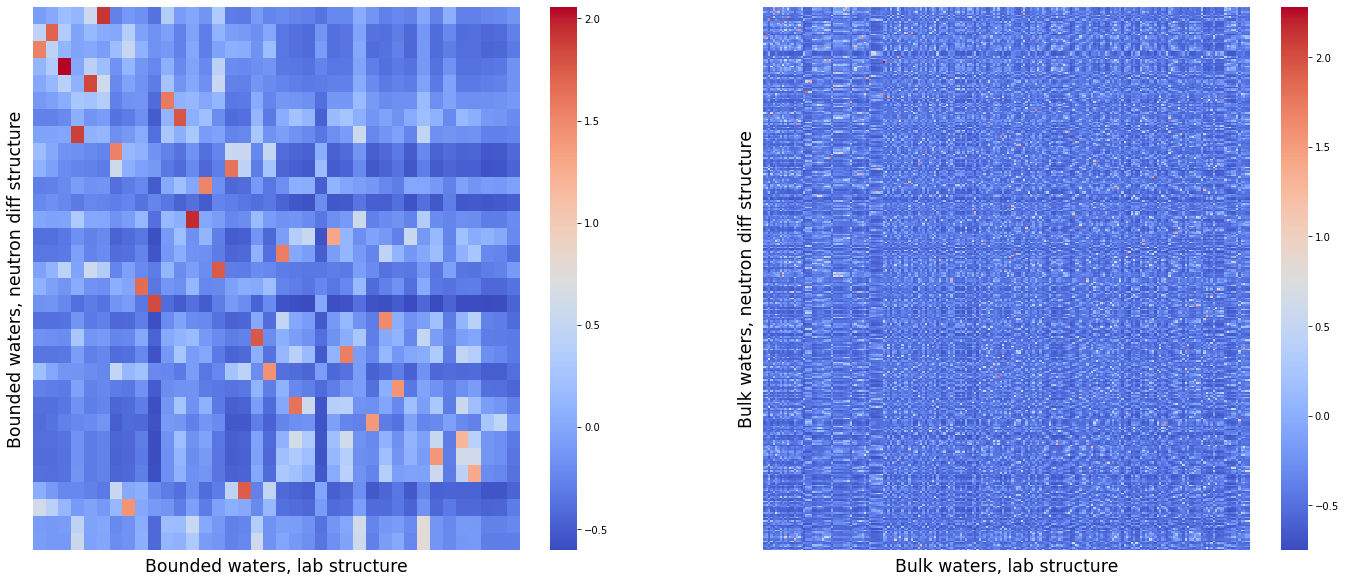

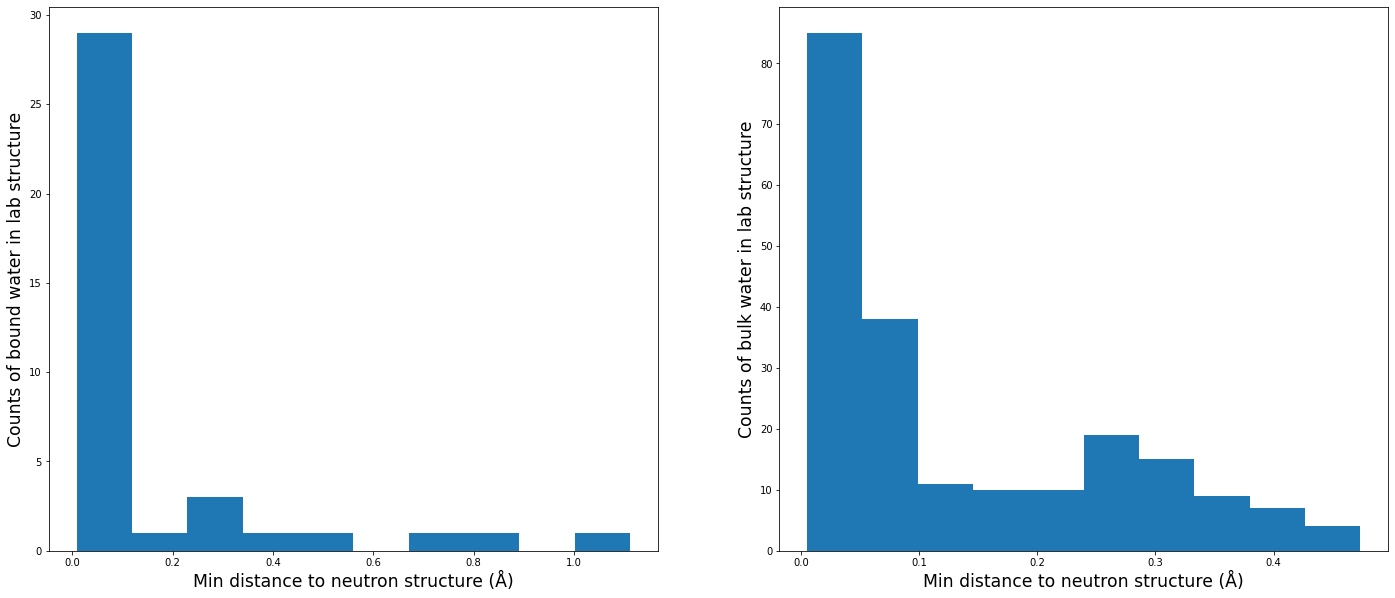

In [5]:
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import seaborn as sns


fig, axs = plt.subplots(1,2, figsize=(24,10))
bounded_waters_pairwise_dist = distance_matrix(neutron_bound_coords, lab_bound_coords)
sns.heatmap(-np.log10(bounded_waters_pairwise_dist), cmap="coolwarm", ax=axs[0],
                      xticklabels=False, yticklabels=False)
axs[0].set_xlabel('Bounded waters, lab structure', fontsize='xx-large')
axs[0].set_ylabel('Bounded waters, neutron diff structure', fontsize='xx-large')

bulk_waters_pairwise_dist = distance_matrix(neutron_bulk_coords, lab_bulk_coords)
sns.heatmap(-np.log10(bulk_waters_pairwise_dist), cmap="coolwarm", ax=axs[1], 
                      xticklabels=False, yticklabels=False)
axs[1].set_xlabel('Bulk waters, lab structure', fontsize='xx-large')
axs[1].set_ylabel('Bulk waters, neutron diff structure', fontsize='xx-large')

fig, axs = plt.subplots(1,2, figsize=(24,10))
axs[0].hist(np.min(bounded_waters_pairwise_dist, axis=0))
axs[0].set_ylabel('Counts of bound water in lab structure', fontsize='xx-large')
axs[0].set_xlabel('Min distance to neutron structure (Å)', fontsize='xx-large')

axs[1].hist(np.min(bulk_waters_pairwise_dist, axis=0))
axs[1].set_ylabel('Counts of bulk water in lab structure', fontsize='xx-large')
axs[1].set_xlabel('Min distance to neutron structure (Å)', fontsize='xx-large')

I take negative log of pairwise dist before making heatmaps to make the close pairs more easy to see. We can clearly see from the heatmap that the waters inside the eGFP, which I refer to as bound waters, correlate well between the two structures. From the histograms, we can see that the even in the bulk waters there are actually quite a few correlated positions, but not as frequent as for the bound waters, which is to be expected. 

Now let us actually copy over the waters from the neutron diffraction structure to the lab structure and delete the previous waters in the latter.

In [6]:
from pymol import cmd
cmd.reinitialize()
cmd.set('pdb_retain_ids', 1) # so it doesn't mess up our residue ids
cmd.load(f'{fname}_3.pdb', 'egfp')
cmd.select('sele', 'resn HOH')
cmd.remove('sele')
cmd.set('pdb_use_ter_records', 0)

cmd.load(f'6l26.pdb', 'neutron')
cmd.select('sele', 'chain B and neutron')
cmd.create('waters', 'sele')
cmd.select('sele', 'waters and resn D3O')
cmd.remove('sele')
cmd.select('sele', 'waters and (not bonded)')
cmd.remove('sele')
cmd.select('sele', 'waters or egfp')
cmd.create('merged', 'sele')
cmd.save(f'lab_fixed.pdb', 'merged')

Good. Now we are done for the moment!


## Appendix
Here's a useful picture for reference, describing the protonation variants (step 4), their name, code, and structure, for the charged amino acids. It's used to code the `assign_protonation_variants` function I used above.

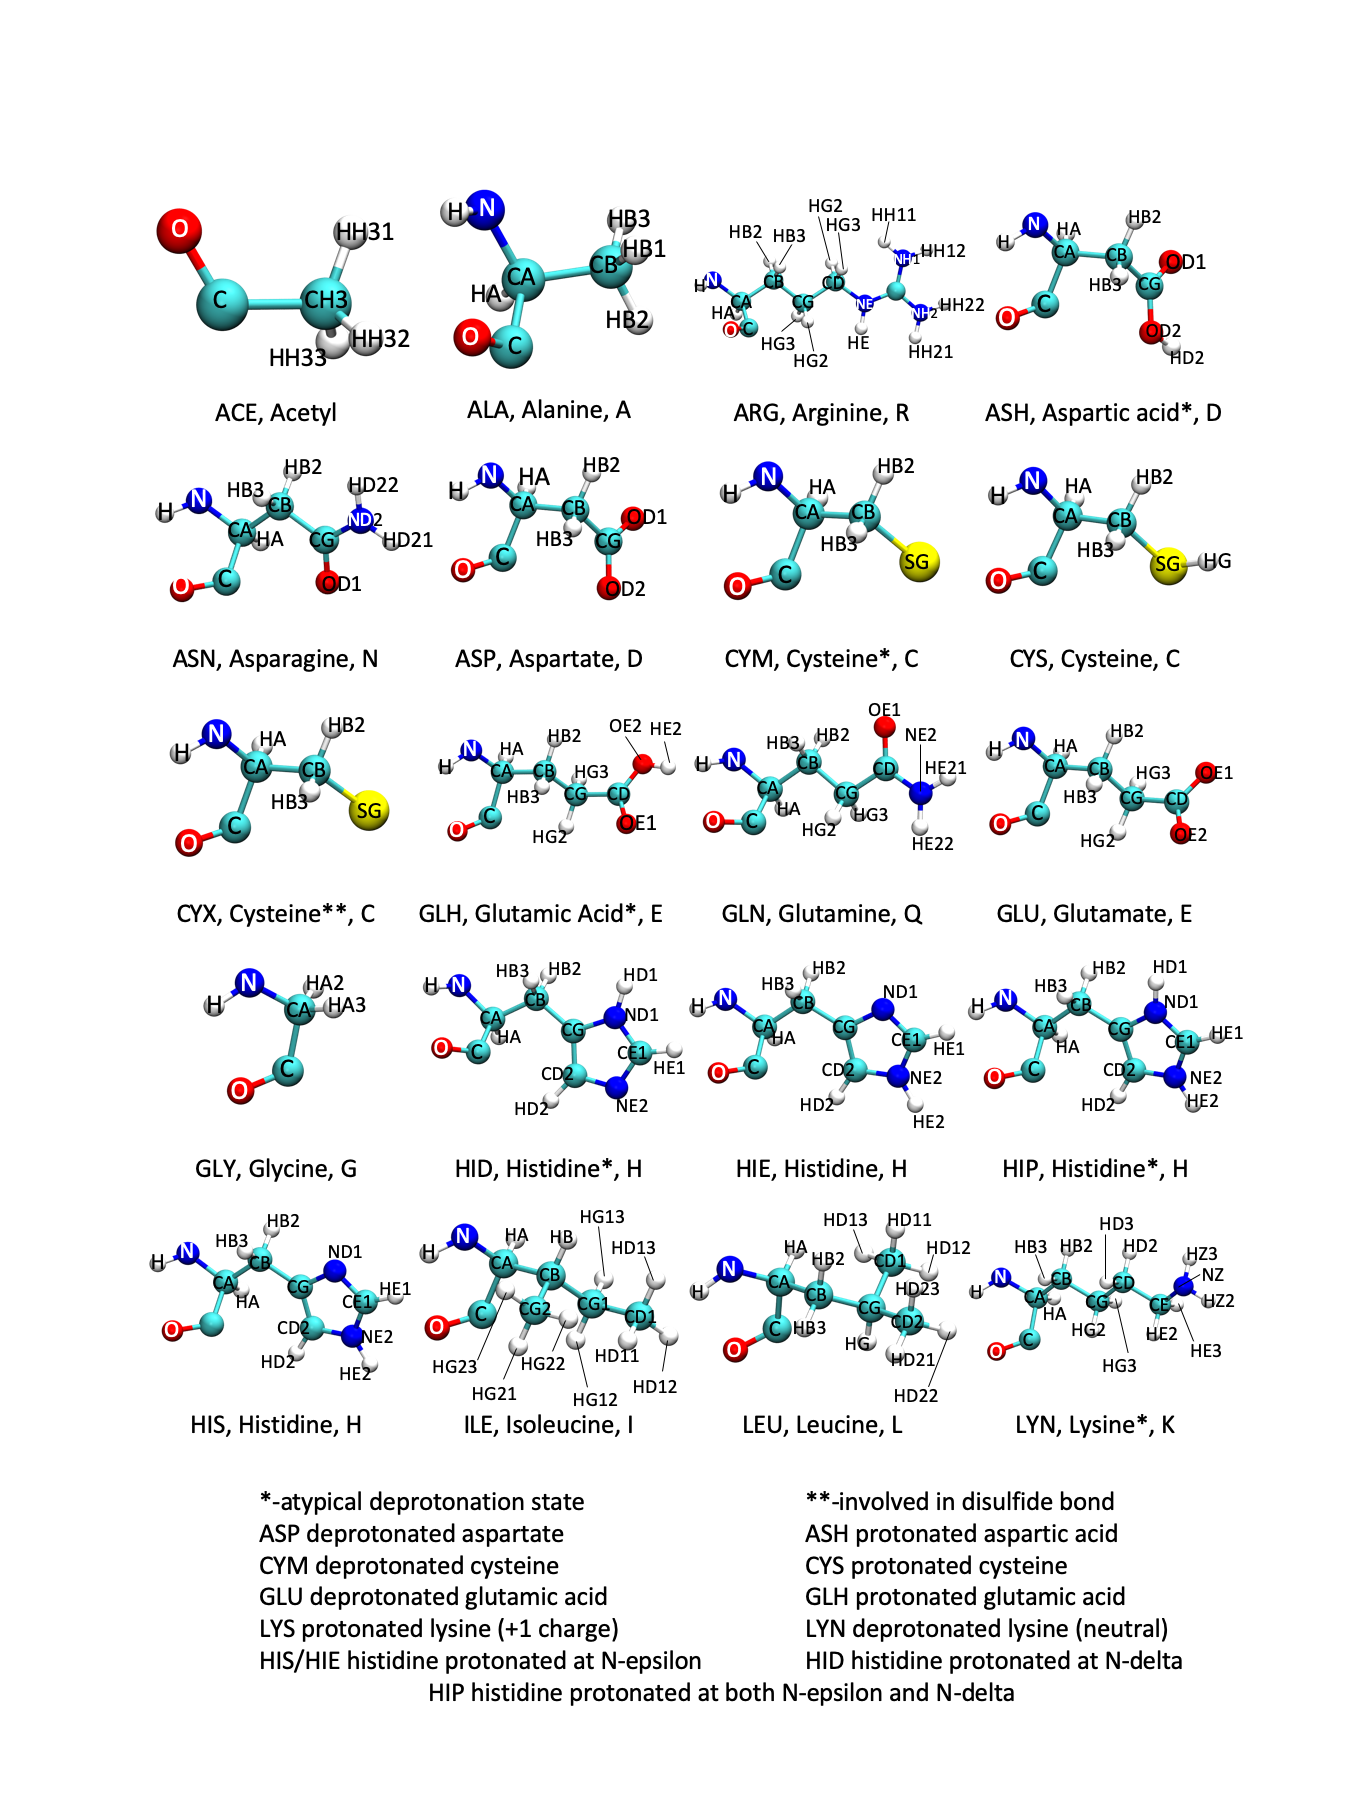

Although it's always a good practice to manually fix the protonation states based on a strong prior biochemical knowledge, sometimes it might be desirable to directly transfer protonation states from a reliably (say, from neutron diffraction) determined structure with a very similar protein sequence, as this can save some time and is always reproducible. My procedure involved three steps:

1. For the reference structure (6jgi) and the target structure (ours), determine the protonation variant for each residue by looking for particular atoms in the topology. We need to do this because an annoying issue with PDB format is that the three-letter amino acid code does not need to reflect the actual protonation variant specified by the residue topology.

2. Do a sequence alignment, i.e., find the longest common subsequence between two sequences via dynamic programming and return tuples of matching indices. Note the input sequences must for each amino acid aliase all variant codes to one unified code.

3. Transfer the protonation variant from the reference structure to the target structure when the matching residues have different protonation states. But to do this easily on OpenMM's topology, we need to use its modeller to add hydrogen, and we need to pass in a list of "masks" (see OpenMM's documentation if this sounds confusing, it is). 

I'll probably convert the script into an utility function to be included in MDTools if I have time to test it on more examples to make sure it's always sensible to follow the steps I described above. As far as I know, there's no existing tool for doing this protonation state transfer. 